In [40]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import cv2
import os
import numpy as np
import random
from scipy.ndimage import rotate

In [42]:
data_path = '/content/drive/MyDrive/cat_dog_small'

In [43]:
categories = os.listdir(data_path)
categories

['cats_set', 'dogs_set']

In [44]:
labels = [i for i in range(len(categories))]
labels

[0, 1]

In [45]:
label_dict = dict(zip(categories, labels))
label_dict

{'cats_set': 0, 'dogs_set': 1}

In [46]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
import time

In [47]:
print("\n=== DATA PREPROCESSING FOR TRANSFER LEARNING ===")

# Load original data without augmentation (same preprocessing as before)
img_size_tl = 224  # ResNet50 requires 224x224 input
data_tl = []
target_tl = []

print(f"Loading data with image size: {img_size_tl}x{img_size_tl}")

for category in categories:
    folder_path = os.path.join(data_path, category)
    image_names = os.listdir(folder_path)

    print(f"Processing {category}...")

    for img_name in image_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Resize for ResNet50 (224x224)
            resized = cv2.resize(gray, (img_size_tl, img_size_tl))
            # Convert grayscale to 3-channel for ResNet50 (RGB format)
            rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

            data_tl.append(rgb_img)
            target_tl.append(label_dict[category])

        except Exception as e:
            print(f'Exception: {e}')

print(f"\nTransfer Learning dataset loaded:")
for category in categories:
    count = target_tl.count(label_dict[category])
    print(f"{category}: {count} images")
print(f"Total images for transfer learning: {len(data_tl)}")


=== DATA PREPROCESSING FOR TRANSFER LEARNING ===
Loading data with image size: 224x224
Processing cats_set...
Processing dogs_set...

Transfer Learning dataset loaded:
cats_set: 250 images
dogs_set: 250 images
Total images for transfer learning: 500


In [48]:
# Convert to numpy array and normalize (ResNet50 expects 0-255, we'll use ImageNet preprocessing)
data_tl = np.array(data_tl, dtype=np.float32)
target_tl = np.array(target_tl)

print(f"Data shape before normalization: {data_tl.shape}")

# ImageNet preprocessing - normalize to [-1, 1] range
from tensorflow.keras.applications.resnet50 import preprocess_input
data_tl = preprocess_input(data_tl)

print(f"Final transfer learning data shape: {data_tl.shape}")
print(f"Data type: {data_tl.dtype}")
print(f"Data range: [{data_tl.min():.3f}, {data_tl.max():.3f}]")

# One-hot encode targets
from tensorflow.keras.utils import to_categorical
target_tl_encoded = to_categorical(target_tl, num_classes=len(categories))
print(f"Transfer learning targets shape: {target_tl_encoded.shape}")

Data shape before normalization: (500, 224, 224, 3)
Final transfer learning data shape: (500, 224, 224, 3)
Data type: float32
Data range: [-123.680, 151.061]
Transfer learning targets shape: (500, 2)


In [49]:
from sklearn.model_selection import train_test_split

print("\n=== TRAIN-TEST SPLIT FOR TRANSFER LEARNING ===")

x_train_tl, x_test_tl, y_train_tl, y_test_tl = train_test_split(
    data_tl, target_tl_encoded,
    test_size=0.2,
    random_state=42,
    stratify=target_tl
)

print(f"Transfer Learning Training set: {x_train_tl.shape[0]} samples")
print(f"Transfer Learning Test set: {x_test_tl.shape[0]} samples")
print(f"Training image shape: {x_train_tl[0].shape}")
print(f"Test image shape: {x_test_tl[0].shape}")


=== TRAIN-TEST SPLIT FOR TRANSFER LEARNING ===
Transfer Learning Training set: 400 samples
Transfer Learning Test set: 100 samples
Training image shape: (224, 224, 3)
Test image shape: (224, 224, 3)


In [50]:
# Load pre-trained ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size_tl, img_size_tl, 3)
)

print(f"Base model loaded: {base_model.name}")
print(f"Number of layers in base model: {len(base_model.layers)}")

Base model loaded: resnet50
Number of layers in base model: 175


In [51]:
# Freeze the base model initially
base_model.trainable = False
print("Base model layers frozen for feature extraction")

Base model layers frozen for feature extraction


In [52]:
# Build the complete model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')  # Binary classification
])

print("\nTransfer Learning Model Architecture:")
transfer_model.summary()


Transfer Learning Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,866,562 (91.04 MB)

 Trainable params: 274,754 (1.05 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [53]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer learning model compiled successfully!")

Transfer learning model compiled successfully!


In [54]:
start_time = time.time()

history_tl_phase1 = transfer_model.fit(
    x_train_tl, y_train_tl,
    validation_data=(x_test_tl, y_test_tl),
    epochs=10,
    batch_size=32,
    verbose=1
)

phase1_time = time.time() - start_time
print(f"Training completed in {phase1_time:.2f} seconds")

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7810 - loss: 0.5306 - val_accuracy: 0.9600 - val_loss: 0.0871
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9871 - loss: 0.0485 - val_accuracy: 0.9600 - val_loss: 0.1382
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9913 - loss: 0.0340 - val_accuracy: 0.9600 - val_loss: 0.1308
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9927 - loss: 0.0136 - val_accuracy: 0.9800 - val_loss: 0.0908
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9955 - loss: 0.0140 - val_accuracy: 0.9800 - val_loss: 0.0728
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9700 - val_loss: 0.0908
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9800 - val_loss: 0.0763
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9949 - loss: 0.0066 - val_accuracy: 0.97

In [55]:
print("Model evaluation on test set:")
test_loss, test_accuracy = transfer_model.evaluate(x_test_tl, y_test_tl)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Model evaluation on test set:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9753 - loss: 0.1311
Test Loss: 0.1054
Test Accuracy: 0.9800


In [56]:
# Make predictions
y_predicted = transfer_model.predict(x_test_tl)
y_predicted_classes = np.argmax(y_predicted, axis=1)
y_actual = np.argmax(y_test_tl, axis=1)

print(f"Prediction probabilities shape: {y_predicted.shape}")
print(f"Predicted classes shape: {y_predicted_classes.shape}")
print(f"Actual classes shape: {y_actual.shape}")

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Prediction probabilities shape: (100, 2)
Predicted classes shape: (100,)
Actual classes shape: (100,)


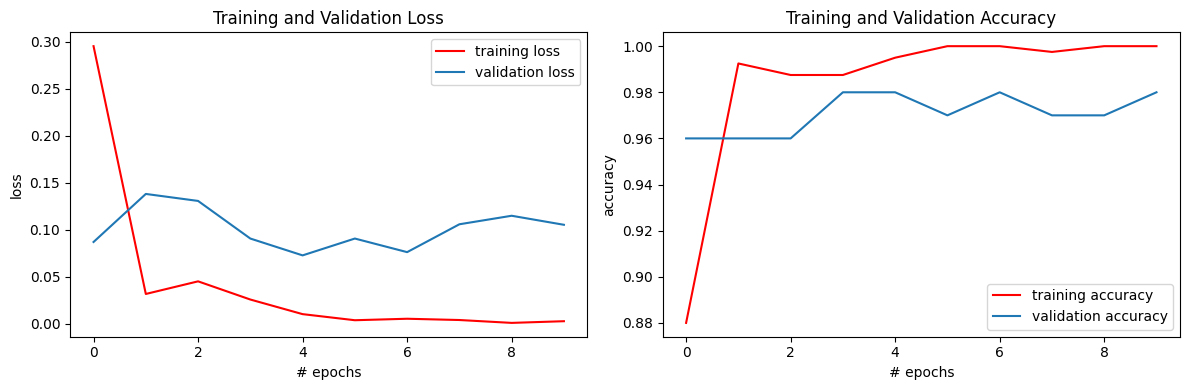

In [57]:
from matplotlib import pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tl_phase1.history['loss'], 'r', label='training loss')
plt.plot(history_tl_phase1.history['val_loss'], label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_tl_phase1.history['accuracy'], 'r', label='training accuracy')
plt.plot(history_tl_phase1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    cats_set       0.96      1.00      0.98        50
    dogs_set       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



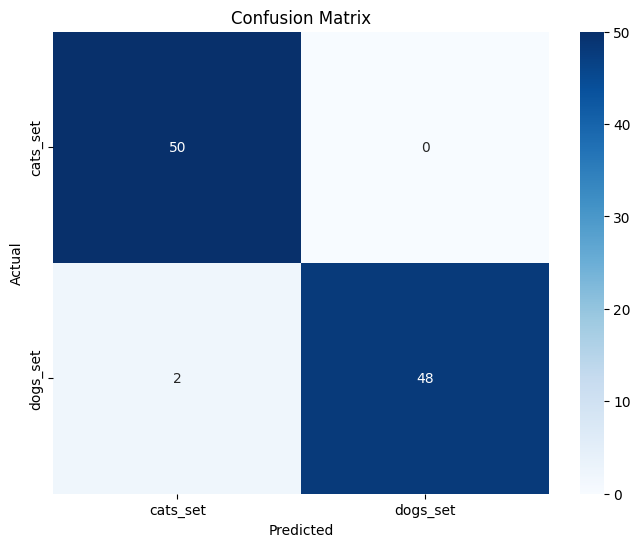

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(y_actual, y_predicted_classes, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_actual, y_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
